# Graph coarsening experiment

This experiment corresponds to appendix A.3 in the paper. Note that the optimization loop (the gradient descent code) is in the `experiments/utils/optimization_loop.py` file

## imports and misc

In [1]:
from pathlib import Path
if "experiments" in Path.cwd().parts:
    %cd ..

import logging
import os
import sys
import warnings
import itertools as it
from time import perf_counter
def append_path(s):
    if s in sys.path:
        return
    sys.path.insert(0, s)

logging.basicConfig(level=logging.WARNING, force=True)

from skimage.filters import threshold_otsu, threshold_yen
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.notebook import trange, tqdm


/home/tristan/research/ot_markov_distances


/home/tristan/.cache/pypoetry/virtualenvs/ot-markov-distances-l3BjNOj2-py3.11/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from ot_markov_distances import discounted_wl_infty as wl_reg_infty
from ot_markov_distances.utils import weighted_transition_matrix, draw_markov
from experiments.utils.modules import ParametricMarkovMatrixWithMatchings, ParametricMarkovMatrix, ParametricMarkovMatrixWithLabels
from experiments.utils.data_generation import get_oriented_circle
from experiments.utils.optimization_loop import opt_loop_batched
from experiments.utils import grid_init, my_threshold, markov_threshold
%load_ext autoreload
%autoreload 2

## Parameters

In [3]:
n_target = 30 #number of points in the target graph
device = torch.device("cuda:2") # torch device to use


## Directed Circle

First we create the original directed circle 

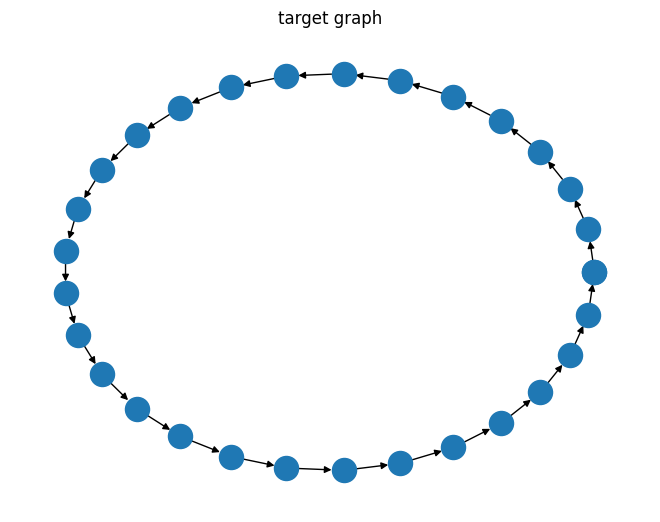

In [4]:
G = get_oriented_circle(n_target) # from utils.data_generation

target_markov = weighted_transition_matrix(G, 0)
target_labels = torch.as_tensor(np.asarray(
        [i for i in nx.get_node_attributes(G, "attr").values()] 
         ), dtype=torch.float32)

nx.draw(G, nx.get_node_attributes(G, "pos"))
plt.title("target graph");

Next let's compute a coarsened version with half the size, using gradient descent as presented in the paper

  0%|          | 0/3000 [00:00<?, ?it/s]

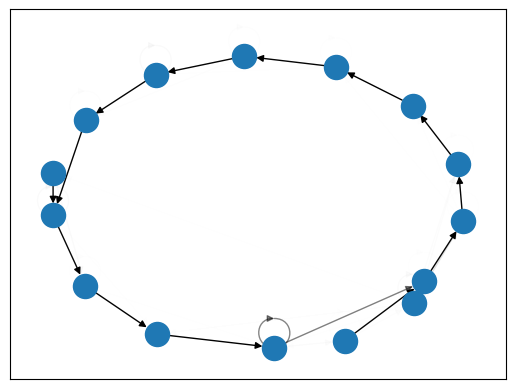

In [5]:
n_coarsened = n_target // 2
target_markov_2 = torch.matrix_power(target_markov, 2) # the square of the original target markov matrix
proj, parameter_values, losses = opt_loop_batched(
        target_markov_2[None, ...],
        labels=target_labels[None, ...],
        projection_size=n_coarsened,
        device=device,
        n_steps=3000,
        heat=1,
        lr=5e-3,
        weight_decay=0,
        run_name=f"circle_coarsening {(run_number:=vars().get('run_number', 0)+1)}",
        wl_parameters = dict(sinkhorn_reg=.05, delta=.5, x_is_sparse=False, y_is_sparse=True),
        #time_factor=2, 
    )
proj.draw()

Now let us try with different coarsened sizes

In [6]:
coarsened_sizes = [5, 10, 15, 20, 25]
  
coarsenings = []

for coarsened_size in coarsened_sizes:
    factor = n_target // coarsened_size
    target_markov_power = torch.matrix_power(target_markov,factor) 
    proj, parameter_values, losses = opt_loop_batched(
        target_markov_power[None, ...],
        labels=target_labels[None, ...],
        projection_size=coarsened_size,
        device=device,
        n_steps=3000,
        heat=1,
        lr=5e-3,
        weight_decay=0,
        run_name=f"circle_coarsening {(run_number:=vars().get('run_number', 0)+1)}",
        wl_parameters = dict(sinkhorn_reg=.05, delta=.5, x_is_sparse=False, y_is_sparse=True),
    )
    coarsenings.append(proj)

    

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

And draw the results

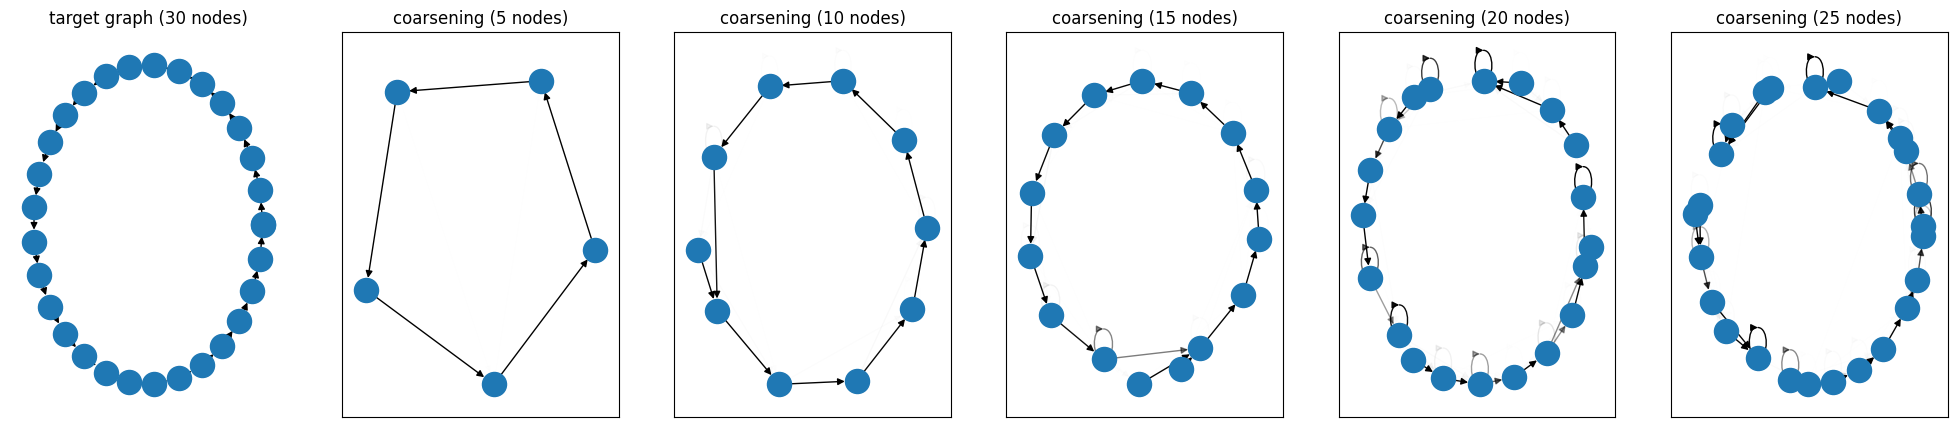

In [7]:
_, axes = plt.subplots(1, len(coarsened_sizes) + 1, figsize =(len(coarsened_sizes)*5, 5))

plt.sca(axes[0])
nx.draw(G, nx.get_node_attributes(G, "pos"))
plt.title(f"target graph ({len(G)} nodes)");

for size, proj, ax in zip(coarsened_sizes, coarsenings, axes[1:]):
    plt.sca(ax)
    proj.draw()
    ax.set_title(f"coarsening ({size} nodes)")
